In [16]:
from __future__ import print_function

import sys

sys.path.extend(['/home/jorg/repository/dcnn_acdc'])

import matplotlib
import matplotlib.pyplot as plt

from matplotlib import cm

from datetime import datetime
from pytz import timezone
import copy

import numpy as np
import torch

import numpy as np
import dill
import os
import glob
from collections import OrderedDict

from in_out.load_data import ACDC2017DataSet
from in_out.detector.detector_dataset import RegionDetectorDataSet
from config.config import config
from common.detector.config import config_detector
from plotting.color_maps import transparent_cmap
from utils.exper_hdl_ensemble import ExperHandlerEnsemble
from common.dslices.config import config
from common.detector.box_utils import find_bbox_object, BoundingBox
from utils.detector.batch_handler import BatchHandler

mycmap = transparent_cmap(plt.get_cmap('jet'))

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# Constants aka fixed variables
ROOT_DIR = "/home/jorg/repository/dcnn_acdc"

# set seeds
SEED = 4325
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.enabled = True
torch.backends.cudnn.deterministic = True
np.random.seed(SEED)

# Load our baseline 
seg_exper_ensemble = ExperHandlerEnsemble(config.exper_dict_brier)

Load experiment from /home/jorg/repository/dcnn_acdc/logs/20180418_15_02_05_dcnn_mcv1_150000E_lr2e02/stats/exper_stats.dll
INFO - Experimental details extracted:: dcnn_mc p=0.10 fold=['0'] loss=brier
Load experiment from /home/jorg/repository/dcnn_acdc/logs/20180426_14_13_46_dcnn_mc_f1p01_brier_150KE_lr2e02/stats/exper_stats.dll
INFO - Experimental details extracted:: dcnn_mc p=0.10 fold=['1'] loss=brier
Load experiment from /home/jorg/repository/dcnn_acdc/logs/20180426_14_14_39_dcnn_mc_f2p01_brier_150KE_lr2e02/stats/exper_stats.dll
INFO - Experimental details extracted:: dcnn_mc p=0.10 fold=['2'] loss=brier
Load experiment from /home/jorg/repository/dcnn_acdc/logs/20180426_14_14_57_dcnn_mc_f3p01_brier_150KE_lr2e02/stats/exper_stats.dll
INFO - Experimental details extracted:: dcnn_mc p=0.10 fold=['3'] loss=brier


In [3]:
from in_out.detector.detector_dataset import create_dataset

dataset = create_dataset(seg_exper_ensemble, train_fold_id=3, quick_run=True, num_of_input_chnls=3)

INFO - Preparing experimental handlers. This may take a while. Be patient...
INFO - Ready. Loop through patient ids.


100%|██████████| 10/10 [00:03<00:00,  3.13it/s]


[ 150.   74.  222.  146.]


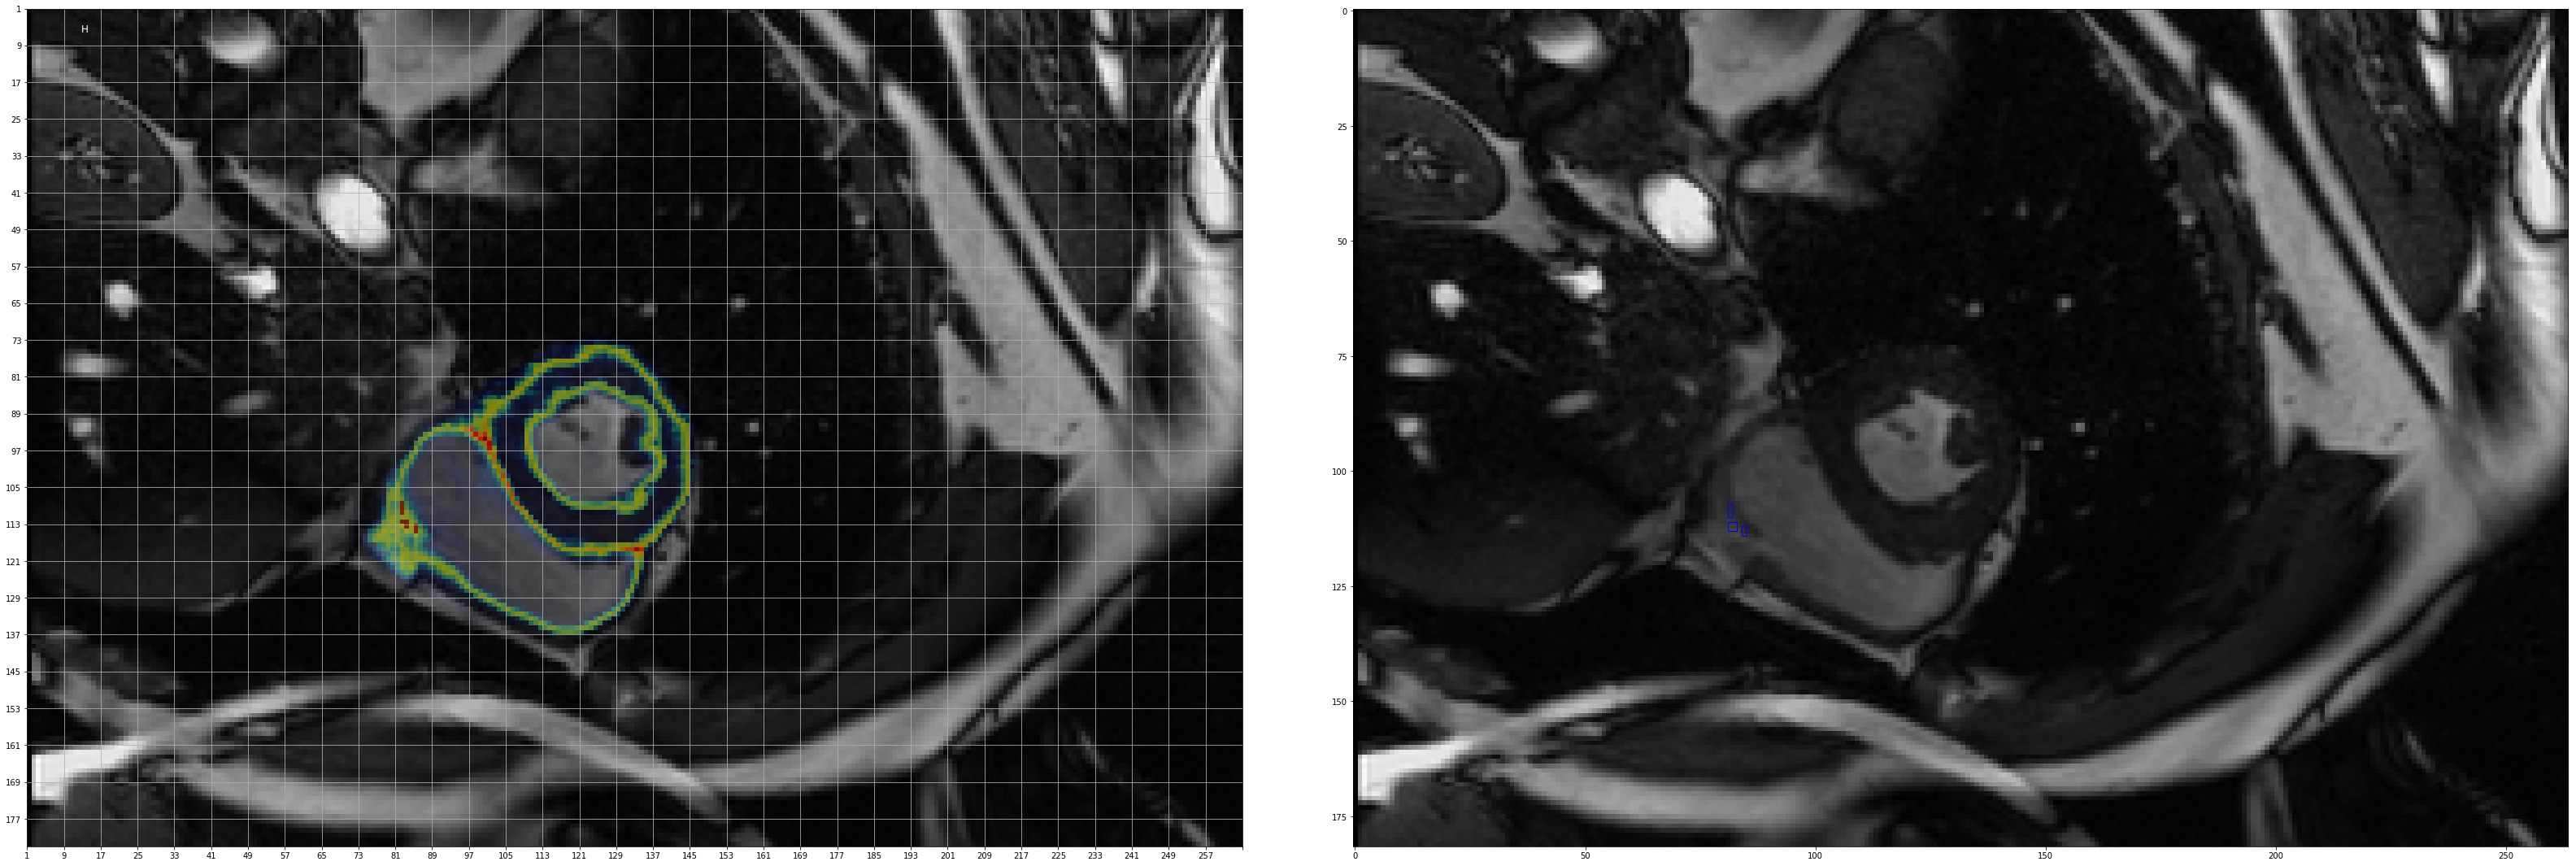

In [68]:
slice_num = 197
batch_nr = 1
image = dataset.train_images[slice_num]
label = dataset.train_labels[slice_num]
bbox = new_batch.batch_bounding_boxes[batch_nr]
bbox = BoundingBox.create(bbox)
print(bbox.box_four)
fig = plt.figure(figsize=(56, 50))

ax1 = plt.subplot2grid((2, 4), (0, 0), rowspan=2, colspan=2)
w, h = image[0].shape
ax1.imshow(image[0], cmap=cm.gray)
ax1.imshow(image[1], cmap=mycmap)
ax1.imshow(label, cmap=mycmap)

ax1.grid(which='minor', color='w', linestyle='-', linewidth=4)
ax1.set_xticks(np.arange(-.5, h, 8))
ax1.set_yticks(np.arange(-.5, w, 8))
ax1.set_xticklabels(np.arange(1, h+1, 8))
ax1.set_yticklabels(np.arange(1, w+1, 8))
ax1.text(12, 4, 'H', size='large',
            ha='center', va='center', color='w')
plt.grid(True)
# ax1.add_patch(bbox.get_matplotlib_patch(color='b'))
ax2 = plt.subplot2grid((2, 4), (0, 2), rowspan=2, colspan=2)
ax2.imshow(image[0], cmap=cm.gray)

for roi_idx in np.arange(dataset.train_lbl_rois[slice_num].shape[0]):
    box_four = dataset.train_lbl_rois[slice_num][roi_idx]
    roi_box = BoundingBox.create(box_four)
    ax2.add_patch(roi_box.get_matplotlib_patch(color='b'))

# ax1.imshow(center_mask, cmap=mycmap)
plt.show()

In [26]:
batch_size = 8
new_batch = BatchHandler(dataset, is_train=True, cuda=False, keep_bounding_boxes=True, verbose=False)
batch_imgs, batch_lbls = new_batch(batch_size=batch_size)
print(new_batch.current_slice_ids)

[282, 266, 97, 14, 325, 28, 327, 20]


In [64]:
target_labels = new_batch.target_labels
# this is a dict with keys 1, 4, 8
grid_labels = target_labels[0]
print(grid_labels.keys())
for g, grid in grid_labels.iteritems():
    print("grid_size ", g, np.count_nonzero(grid))
    if isinstance(grid, np.ndarray):
        print(np.where(grid != 0))

[8, 1, 4]
grid_size  8 3
(array([40, 69, 70]),)
grid_size  1 1
grid_size  4 7
(array([153, 171, 265, 266, 267, 284, 285]),)


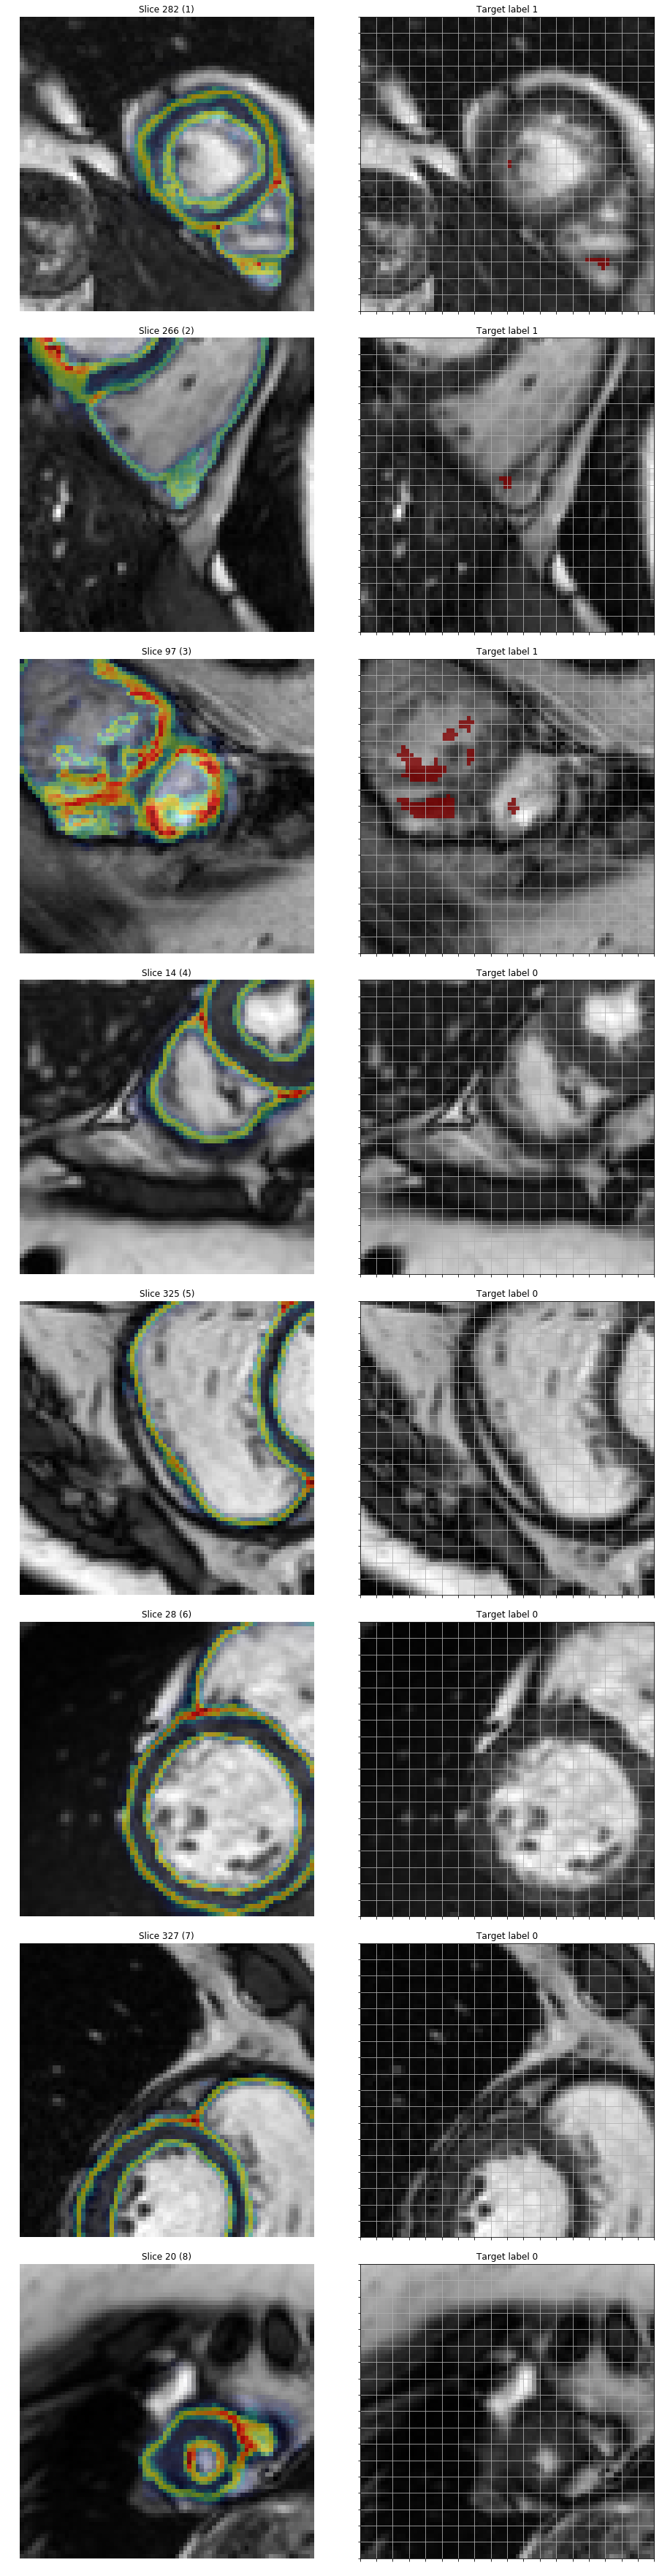

In [69]:
new_batch.visualize_batch(grid_spacing=4)

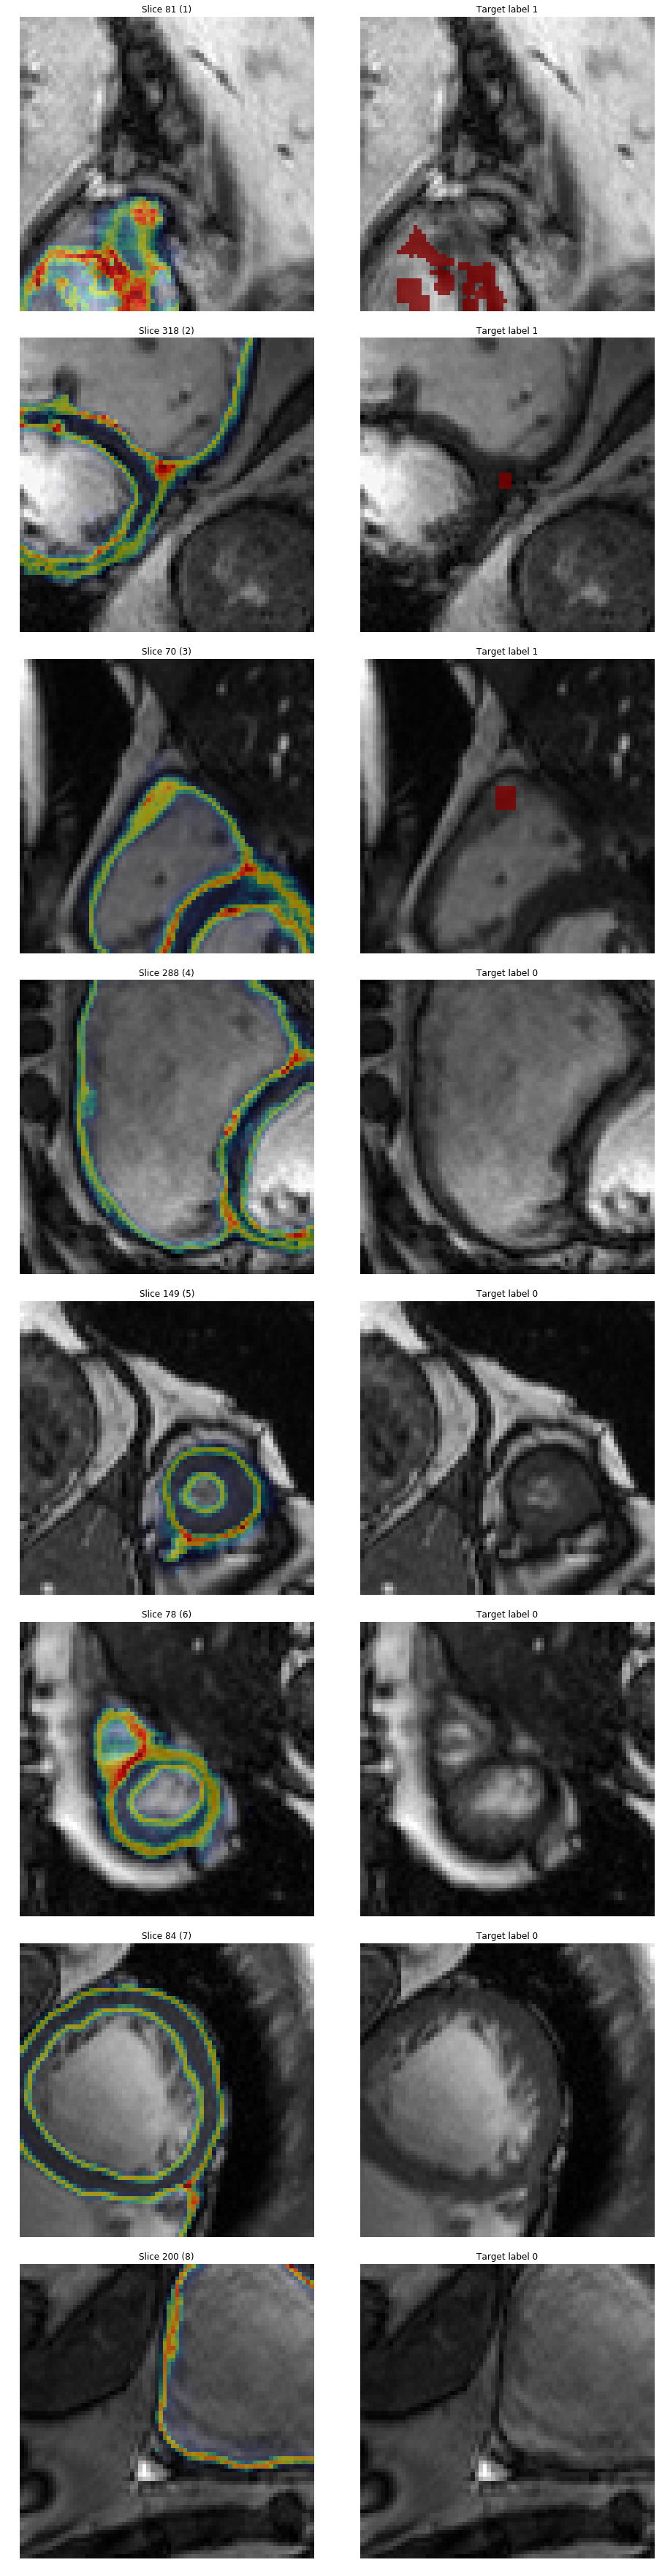

In [100]:
width = 16
height = batch_size * 8
columns = 4
rows = batch_size * 2   # 2 because we do double row plotting 
column = 0
row = 0
fig = plt.figure(figsize=(width, height))

for idx in np.arange(batch_size):
    slice_num = new_batch.current_slice_ids[idx]
    image_slice = batch_imgs[idx][0]
    uncertainty_slice = batch_imgs[idx][1]
    pred_labels_slice = batch_imgs[idx][2]
    target_lbl_binary = batch_lbls[idx]
    target_slice = new_batch.batch_label_slices[idx]
    ax1 = plt.subplot2grid((rows, columns), (row, 0), rowspan=2, colspan=2)
    ax1.set_title("Slice {} ({})".format(slice_num, idx + 1))
    ax1.imshow(image_slice, cmap=cm.gray)
    ax1.imshow(uncertainty_slice, cmap=mycmap)
    plt.axis("off")
    
    ax2 = plt.subplot2grid((rows, columns), (row, 2), rowspan=2, colspan=2)
    ax2.imshow(image_slice, cmap=cm.gray)
    ax2.set_title("Target label {}".format(int(target_lbl_binary)))
    ax2.imshow(target_slice, cmap=mycmap)
    plt.axis("off")
    row += 2